In [17]:
import numpy as np, matplotlib.pyplot as plt, os
from importlib import reload
import xarray as xr, jax.numpy as jnp

import data, pipelines, utils, net, infer, simulation

In [18]:
data.B0_base_DEF = 7
simulation.num_flip_pulses = 1 
simulation.flip_angle = 90 * jnp.pi / 180

simulation.tpulse_DEF = 2.5
simulation.tdelay_DEF = 0.1
simulation.n_pulses_DEF = 1
simulation.DO_SL = False

In [19]:
xarr_name = './data/ped_tumor_mice_C3_2R_2024-11-20_MT_rNOE.nc'
xarr_name = '~/Downloads/adult_mice_data.nc'
data_xa = xr.open_dataset(xarr_name) 

data_feed_mt = data.SlicesFeed.from_xarray(data_xa, mt_or_amide='mt')

In [20]:
data_xa

<xarray.Dataset> Size: 1MB
Dimensions:            (height: 64, slice: 1, width: 64, MRF_cycles: 31)
Dimensions without coordinates: height, slice, width, MRF_cycles
Data variables:
    roi_mask_nans      (height, slice, width) float64 33kB nan nan ... nan nan
    B1_fix_factor_map  (height, slice, width) float64 33kB nan nan ... nan nan
    B0_shift_ppm_map   (height, slice, width) float64 33kB 0.0 0.0 ... 0.0 0.0
    T2ms               (height, slice, width) float64 33kB 0.0 48.33 ... 0.0 0.0
    T1ms               (height, slice, width) float64 33kB 1.405e+03 0.0 ... 0.0
    MT_data            (MRF_cycles, height, slice, width) float64 1MB 58.0 .....

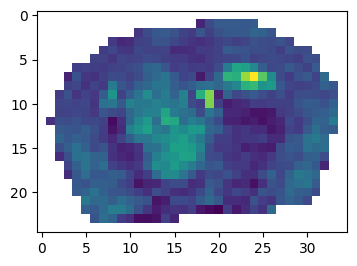

In [21]:
data_xa_cutout = data_xa.isel(
    height=slice(13, 38),
    width=slice(19, 54)
)
plt.figure(figsize=(4,4))
plt.imshow((data_xa_cutout['T1ms'].data * data_xa_cutout['roi_mask_nans']).squeeze())
# 17:43, 16:50

data_feed_mt = data.SlicesFeed.from_xarray(data_xa_cutout, mt_or_amide='mt')

In [22]:
pipelines.pipeline_config.train_config.std_up_fact = 0.2
pipelines.pipeline_config.mt_lr = 0.01
pipelines.pipeline_config.mt_steps = 500
pipelines.pipeline_config.infer_config.kc_scale_fact = 80
pipelines.pipeline_config.train_config.auto_reduce_batch = False
pipelines.pipeline_config.train_config.tp_noise_augmentation_burn_in = 50
net.MyMLP.sigmoid_scale_fac = 10  # priority for center of range

data_feed_mt.ds = 1
data_feed_mt.slw = 1

predictor_mt, _ = pipelines.run_train(
    brain2train_mt=data_feed_mt, 
    brain2train_amide=None, 
    ckpt_folder=os.path.abspath(f'./goo'),     
    do_amide=False,
    mt_sim_mode = 'expm_bmmat'
) 
# TODO 7T !! 

2025-04-29 21:58:38.571955: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


pseudo-epochs = 500
effective epochs = 500


  0%|                                                                                                                        | 0/500 [00:00<?, ?it/s]2025-04-29 21:58:40.802869: W external/xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
loss_total = 6.83,signal reconstruction error (%) = 3.66 (MA: 4.36):  83%|█████████████████████████████████▉       | 414/500 [02:43<00:33,  2.53it/s]


Met early stopping criteria, breaking at pseudo-epoch 413


In [23]:
data_feed_mt.ds = 1    
mt_tissue_params_est, nn_pred_signal_normed_np = infer.infer(
    data_feed_mt, nn_predictor=predictor_mt, 
    do_forward=True, pool2predict='c'
    )

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.56s/it]


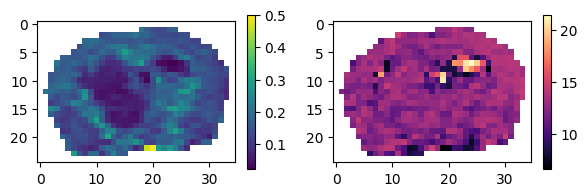

In [24]:
plt.figure(figsize=(7, 2)) 
plt.subplot(1,2,1)
# [15:45,0,15:50]
plt.imshow(mt_tissue_params_est['fc_T'].squeeze());               plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(mt_tissue_params_est['kc_T'].squeeze(), cmap='magma'); plt.colorbar()

In [25]:
#plt.imshow(nn_pred_signal_normed_np[15,:,0,:])

/tmp/ipykernel_1835654/2978797100.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_nrmse = plt.cm.get_cmap("YlOrRd").copy();  cmap_nrmse.set_bad('1.0')


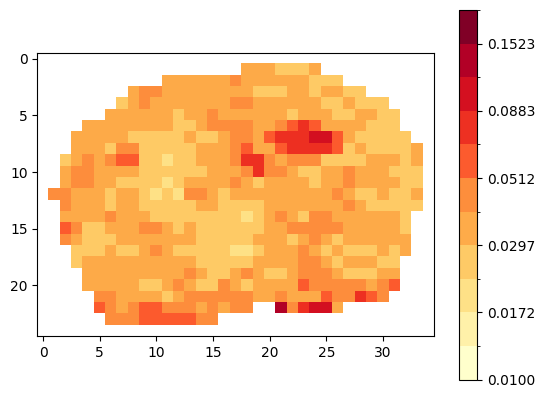

In [26]:
import matplotlib.colors as mcolors

# Visualize the error maps in a slightly more informative way
err_mt = np.linalg.norm(nn_pred_signal_normed_np - data_feed_mt.measured_normed_T, axis=0) \
    / np.linalg.norm(data_feed_mt.measured_normed_T, axis=0)

log_bins = np.logspace(np.log10(1.), np.log10(20), num=12)/100  # logarithmic
# log_bins = np.arange(0., 0.14, 0.01)  # Similar to R^2 coloring in paper
norm = mcolors.BoundaryNorm(log_bins, ncolors=plt.get_cmap('hot_r').N, clip=True)

cmap_nrmse = plt.cm.get_cmap("YlOrRd").copy();  cmap_nrmse.set_bad('1.0')
img0 = plt.imshow(err_mt[:,0,:], norm=norm, cmap=cmap_nrmse) #'hot_r'); # plt.colorbar(img0)  # vmin=0, vmax=0.1,

cbar = plt.colorbar(img0)

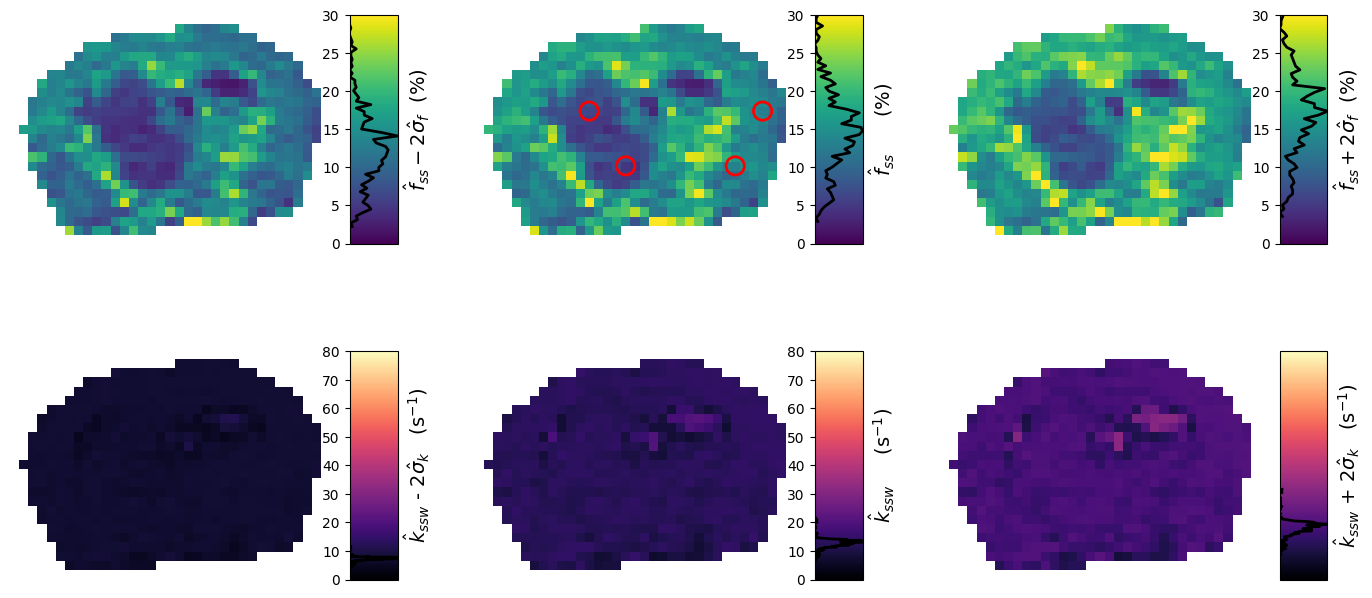

In [43]:
import analyze_uncertainty as au
reload(au)

mt_tissue_param_est = mt_tissue_params_est

k_val = mt_tissue_param_est['kc_T'] # [:,sli,:]
f_val = 100*mt_tissue_param_est['fc_T'] #[:,sli,:]
u = mt_tissue_param_est['ucov'].reshape((*data_feed_mt.shape, 2, 2))
s = mt_tissue_param_est['scov'].reshape((*data_feed_mt.shape, 2, 2))
cov = mt_tissue_param_est['cov'].reshape((*data_feed_mt.shape, 2, 2))

dfk = np.array([1, 0])[None, None, None, :, None] 
dfk = u @ jnp.sqrt(s) @ dfk
df_c_0 = dfk[..., 0, 0] * infer.infer_config.fc_scale_fact 
dk_ca_0 = dfk[..., 1, 0] * infer.infer_config.kc_scale_fact 
dfk = np.array([0, 1])[None, None, None, :, None] 
dfk = u @ jnp.sqrt(s) @ dfk
df_c_1 = dfk[..., 0, 0] * infer.infer_config.fc_scale_fact 
dk_ca_1 = dfk[..., 1, 0] * infer.infer_config.kc_scale_fact 

f_total = np.sqrt(df_c_0**2 + df_c_1**2)
k_total = np.sqrt(dk_ca_0**2 + dk_ca_1**2)

f_sigma = 100*f_total
k_sigma = k_total

sli = 0
fig, axes = plt.subplots(2, 3, figsize=(17, 8))
explore_amide_uncertainty = False

map = f_val[:,sli,:] - 2*f_sigma[:,sli,:]
img = axes[0, 0].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');  
cbar = au.cbarhist(img, map,axes[0, 0], pad=0.2) 
cbar.set_label(r'$\hat{f}_{ss} - 2\hat{\sigma}_f$  (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = f_val[:,sli,:]
img = axes[0, 1].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');  
cbar = au.cbarhist(img, map,axes[0, 1], pad=0.2) 
cbar.set_label(r'$\hat{f}_{ss}$      (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = f_val[:,sli,:] + 2*f_sigma[:,sli,:]
img = axes[0, 2].imshow(map, vmin=0, vmax=30 if not explore_amide_uncertainty else 1, cmap='viridis');  
cbar = au.cbarhist(img, map, axes[0, 2], pad=0.2) 
cbar.set_label(r'$\hat{f}_{ss} + 2\hat{\sigma}_f$  (%)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
#cbar.set_label(r'f$_{ss}$ (%) :  $\mu+2\sigma$', fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:] - 2*k_sigma[:,sli,:]
img = axes[1, 0].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');  
cbar = au.cbarhist(img, map,axes[1, 0], pad=0.2) 
cbar.set_label(r'$\hat{k}_{ssw}$ - 2$\hat{\sigma}_k$   (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:]
img = axes[1, 1].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');  
cbar = au.cbarhist(img, map,axes[1, 1], pad=0.2) 
cbar.set_label(r'$\hat{k}_{ssw}$     (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')
map = k_val[:,sli,:] + 2*k_sigma[:,sli,:]
img = axes[1, 2].imshow(map, vmin=0, vmax=80 if not explore_amide_uncertainty else 500, cmap='magma');  
cbar = au.cbarhist(img, map, axes[1, 2], pad=0.2) 
cbar.set_label(r'$\hat{k}_{ssw}$ + 2$\hat{\sigma}_k$   (s$^{-1}$)'.replace('ss', 's' if explore_amide_uncertainty else 'ss'), fontsize=14)
cbar.ax.yaxis.set_ticks_position('left')

for ax in axes.flatten():
    utils.remove_spines(ax)

import matplotlib.patches as patches

points = [[10, 12], [16, 16], [10, 31], [16, 28]]
for point in points:
    circle = patches.Circle((point[1], point[0]), 1, facecolor='none', edgecolor='red', linewidth=2)
    axes[0, 1].add_patch(circle)
    #axes[0, 1].set_ylim(map.shape[0], 0) 

In [41]:
scales = np.array((100 * infer.infer_config.fb_scale_fact, infer.infer_config.kb_scale_fact)) if explore_amide_uncertainty \
    else np.array((100 * infer.infer_config.fc_scale_fact, infer.infer_config.kc_scale_fact))     

_cov = u @ s @ np.transpose(u, [0,1,2,4,3]) 

# fig, axes = plt.subplots(1, 4, figsize=(20, 4)) #, figsize=(7, 3))
# jjj = 4
# for ax, (_x, _y) in zip(axes, [[25, 40], [30, 40], [25, 25], [30, 25]]):
#     # au.plot_empirical_nrmse_blob(ax, _x, _y, sli)        
#     au.plot_ellipse(ax, _x, _y, sli, f_val, k_val, df_c_0, dk_ca_0, df_c_1, dk_ca_1, amide=explore_amide_uncertainty)    
#     plt.plot()
#     f_best, k_best, nrmse, _df, _dk = au.plot_empirical_nrmse_blob(
#         ax, _x, _y, sli, 
#         data_feed_mt, mt_tissue_param_est,
#         data_feed_amide=None, amide=explore_amide_uncertainty,
#         mt_sim_mode='expm_bmmat', 
#     )    

#     diff = np.array((f_val[_x, sli, _y] - f_best, k_val[_x, sli, _y] - k_best)) # / scales
#     mahalanobis = np.sqrt( (diff/scales).T @ np.linalg.inv(_cov[_x, sli, _y].T) @ (diff/scales) )
#     #mahalanobis = diff.T @ np.linalg.inv(scales[None, :] * _cov[_x, sli, _y] * scales[:, None]) @ diff
#     ax.set_title(mahalanobis)

/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


(1, 1, 1, 1, 1, 1, 100, 100)


  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]
/tmp/ipykernel_1835654/3757412185.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


(1, 1, 1, 1, 1, 1, 100, 100)


  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]
/tmp/ipykernel_1835654/3757412185.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


(1, 1, 1, 1, 1, 1, 100, 100)


  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.52it/s]
/tmp/ipykernel_1835654/3757412185.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()
/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)


(1, 1, 1, 1, 1, 1, 100, 100)


  0%|                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/alexf/nbmf_public/data.py:443: RuntimeWarning: All-NaN slice encountered
  signal_pixelwise_norm = np.nanmax(signal, axis=0)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.60it/s]
/tmp/ipykernel_1835654/3757412185.py:18: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


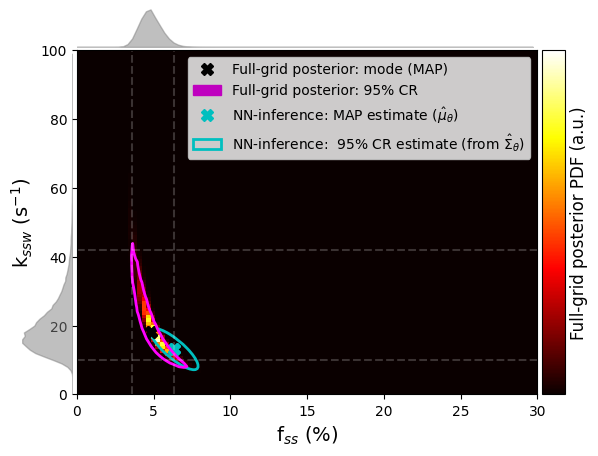

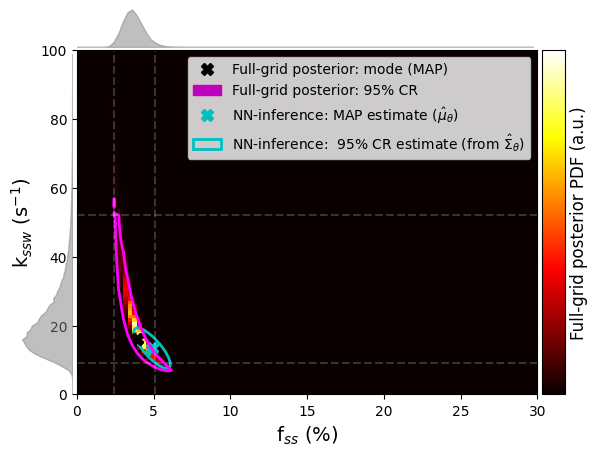

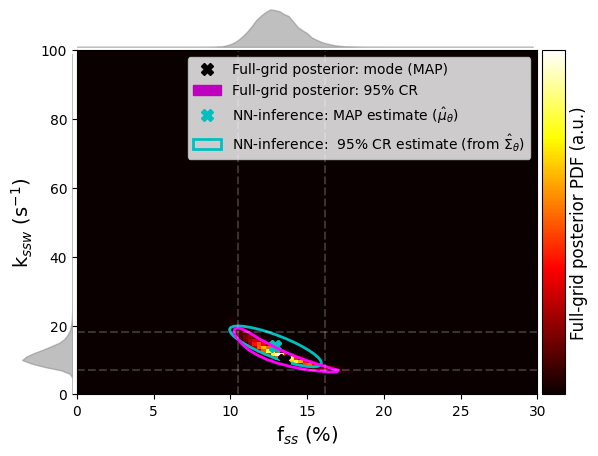

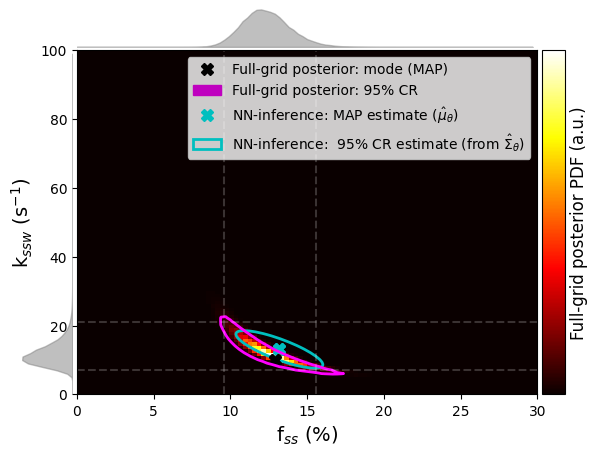

In [42]:
_z = 0
reload(au)

for jj, (_x, _y) in enumerate(points): # [[8, 24], [13, 24], [8, 9], [13, 9]]):    
    f_best, k_best, nrmse, _df, _dk = au.plot_empirical_nrmse_blob(
        None, _x, _y, _z, 
        data_feed_mt, mt_tissue_param_est,
        data_feed_amide=None, amide=False,
        mt_sim_mode='expm_bmmat', do_plot=False
    )          
    maha1, maha2, posterior_cov, CR_area, CIk_x_CIf = au.viz_posteriors(
        f_val, k_val, _x, _y, _z,
        _cov, df_c_0, dk_ca_0, df_c_1, dk_ca_1,
        f_best, k_best, nrmse, _df, _dk,
        explore_amide_uncertainty=explore_amide_uncertainty, fontsize=14, # figsize=(6, 4),  # good w.o. marginals
        do_marginals=True, figsize=[7, 5], show_text=False, show_NN=True
        )    
    plt.tight_layout()
    # plt.savefig(f'./mouse_posterior_pics/ind{jj}_{_x}_{_z}_{_y}.png', dpi=200)
